In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, TheilSenRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("train.csv", index_col=0).drop(["Surname", "CustomerId"], axis=1)
test = pd.read_csv("test.csv", index_col=0).drop(["Surname", "CustomerId"], axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
def featuer_engineering(data):
    # Age
    data["Age_order_by_quantity"] = pd.qcut(data["Age"], q = 5)
    data["Age_groups"] = pd.cut(data["Age"], bins = 3)
    data["Gender_IsActive"] = data["Gender"]
    data["Log(AGE)"] = (np.log(data["Age"]))
    data["Age dagree = 4"] = data["Age"] ** 4 

    # Balance
    data["Balance_group"] = pd.cut(data["Balance"] , bins=5)


    # Number of Products
    data["IsActive + Products"] = data["NumOfProducts"] * (5 * data["IsActiveMember"])
    # age_bins = [18, 32, 42, 92]
    # age_labels = ["Young", "Medium", "Senior"]

    # data["AgeGroup"] = pd.cut(data["Age"], bins=age_bins, labels=age_labels)
    
    # data["Country_male_age_isactive"] = data["Geography"].astype(str) + "_" + data["Gender"].astype(str) + "_" + data["AgeGroup"].astype(str) + df["IsActiveMember"].astype(str)

In [4]:
df["Age"].describe()

count    165034.000000
mean         38.125888
std           8.867205
min          18.000000
25%          32.000000
50%          37.000000
75%          42.000000
max          92.000000
Name: Age, dtype: float64

In [5]:
WoE_values = {}

def WoE(data, col, target):
    event = data[target].sum()
    non_event = len(data) - event

    grouped = data.groupby(col)[target].agg(['sum', 'count'])
    grouped['non_events'] = grouped['count'] - grouped['sum']
    
    grouped['event_rate'] = grouped['sum'] / event
    grouped['non_event_rate'] = grouped['non_events'] / non_event
    grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
    woe_dict = grouped['woe'].to_dict()
    WoE_values[col] = woe_dict

In [6]:
def featuer_engineering_woe(data):
    for i in WoE_values:
        data[i + "_WoE"] = data[i].map(WoE_values[i]).astype(float)
        

In [7]:
featuer_engineering(df)
featuer_engineering(test)


In [8]:
WoE(df, "Geography", "Exited")
WoE(df, "Gender", "Exited")
WoE(df, "Age_order_by_quantity", "Exited")
WoE(df, "Age_groups", "Exited")
WoE(df, "Balance_group", "Exited")
WoE(df, "NumOfProducts", "Exited")

In [9]:
featuer_engineering_woe(df)
featuer_engineering_woe(test)
df["Age_groups_WoE /0.5"] = df["Age_groups_WoE"] // 0.5
# df["NP_WoE/0.5"] = np.log(df["NumOfProducts_WoE"]) + 2 
# df["Balance_group_WoE /0.5"] = df["Balance_group_WoE"] // 0.5
test["Age_groups_WoE /0.5"] = test["Age_groups_WoE"] // 0.5

<Axes: >

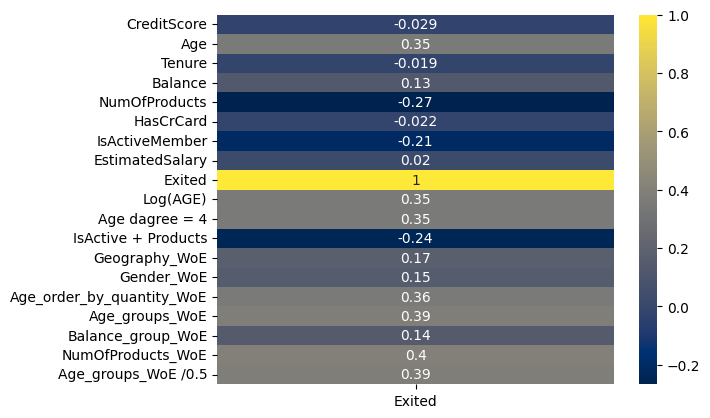

In [10]:
sns.heatmap(df.select_dtypes(include=['number']).corr(method="spearman")[["Exited"]], annot=True, cmap="cividis")


<Axes: >

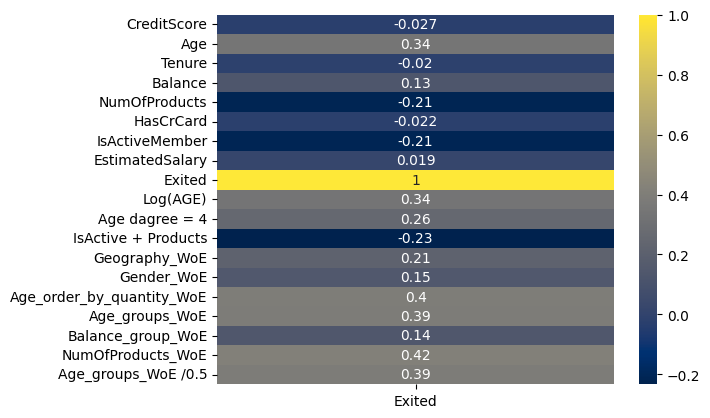

In [11]:
sns.heatmap(df.select_dtypes(include=['number']).corr(method="pearson")[["Exited"]], annot=True, cmap="cividis")


In [12]:
X = df.select_dtypes(include=['number']).drop(['Exited', "Tenure"], axis=1) 
y = df['Exited']
test = test.select_dtypes(include=['number']).drop(["Tenure"], axis=1)
poly = PolynomialFeatures(degree=3, include_bias=False)  
X_poly = poly.fit_transform(X)
test = poly.transform(test)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)
test = scaler.transform(test)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [23]:
# model = LogisticRegression(max_iter = 570)  # ---> 550 max_iter


from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('ridge', RidgeClassifier())
])

logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(max_iter=570))
])

# Create the StackingClassifier without probability stacking for Ridge
ensemble_model = StackingClassifier(
    estimators=[
        ('ridge', ridge_pipeline),
        ('logreg', logreg_pipeline)
    ],
    final_estimator=LogisticRegression(max_iter=570),  # Meta-model
    stack_method='auto'  # This will use 'predict' for RidgeClassifier and 'predict_proba' for LogisticRegression
)


ensemble_model.fit(X_scaled, y)

pred = ensemble_model.predict_proba(X_test)[:,1]
ras = roc_auc_score(y_test, pred)

In [24]:
print(ras, 0.8906086594009369 <= ras, ras - 0.8906086594009369)

0.8900070179356869 False -0.0006016414652499913


In [25]:
pred

array([0.11424986, 0.04920864, 0.90937609, ..., 0.23083272, 0.05625402,
       0.84028938])

In [26]:
test

array([[-0.87954617, -1.70582888, -0.8831633 , ..., -0.62927224,
        -0.93268269, -0.56924136],
       [ 0.33139326,  0.88800657, -0.8831633 , ...,  0.60724651,
         0.8765047 ,  1.77171112],
       [-0.00567235, -0.46529888, -0.8831633 , ..., -0.62927224,
        -0.93268269, -0.56924136],
       ...,
       [ 0.6934267 , -0.80362525, -0.8831633 , ..., -0.62927224,
        -0.93268269, -0.56924136],
       [ 0.65597497, -0.69084979, -0.8831633 , ...,  0.14659132,
         0.8765047 , -0.56924136],
       [-0.44260926, -0.12697252,  0.51530731, ...,  0.14659132,
         0.8765047 , -0.56924136]])

In [27]:
sub = pd.read_csv('sample_submission.csv')

sub["Exited"] = ensemble_model.predict_proba(test)[:,1]

sub.to_csv("sub.csv", index = False)